# Gradient Boosted Trees

So far decision trees are the most accurate models in predicting the classes. Random Forest and Gradient Boosted trees perform somewhat similarly.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

## Load Data

In [9]:
df, train, test = load_data.load_coral_data(complete=True, CV=True, convert_to_categorical=True)
print(train.shape)

(496, 44)


## Data Prep

In [10]:
train_X, train_y, pred_names = load_data.get_features_and_response(train)

In [11]:
print(train_X.shape)
pred_names

(496, 20)


Index(['Effluent', 'Sedimentation', 'New_Development', 'Habitat_Modification',
       'Invasive_Algae', 'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth'],
      dtype='object')

# Try Cross Validation Code from Logistic

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, zero_one_loss
import time
num_trees = [1, 10, 50, 100, 150, 200, 250, 300]
depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
hyperparameters = dict(n_estimators=num_trees, max_depth=depth)

begin = time.time()
clf = GridSearchCV(sklearn.ensemble.GradientBoostingClassifier(random_state=229), 
                  hyperparameters, cv=5, verbose=1, iid=False,
                  scoring = make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                  return_train_score=True)
best_model = clf.fit(train_X, train_y)

print("That took {} seconds".format(time.time() - begin))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


That took 208.08761429786682 seconds


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  3.5min finished


In [13]:
# # Best Model is the model picked with the optimal C retrained on the
# # entire training data.

print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

Best n_estimators: 100
Best max_depth: 1


In [14]:
# from scikit-learn, "Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV" 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
results = clf.cv_results_

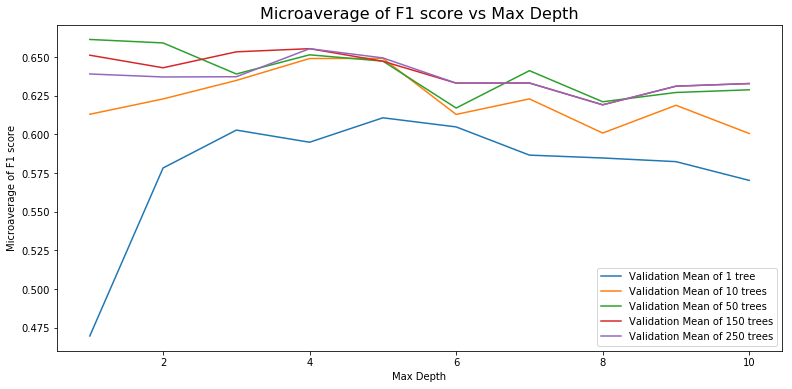

In [19]:
plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs Max Depth",
          fontsize=16)

plt.xlabel("Max Depth")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_depth'].data, dtype=float)
X_axis_unique = np.unique(X_axis)

sample_score_mean = results['mean_test_score']
# sample_score_std = results['std_test_score']

train_score_mean = results['mean_train_score']

plt.plot(X_axis_unique, sample_score_mean[range(0,80,8)], label='Validation Mean of 1 tree')
plt.plot(X_axis_unique, sample_score_mean[range(1,81,8)], label='Validation Mean of 10 trees')
plt.plot(X_axis_unique, sample_score_mean[range(2,82,8)], label='Validation Mean of 50 trees')
plt.plot(X_axis_unique, sample_score_mean[range(4,84,8)], label='Validation Mean of 150 trees')
plt.plot(X_axis_unique, sample_score_mean[range(6,86,8)], label='Validation Mean of 250 trees')

plt.legend()

plt.grid(False)

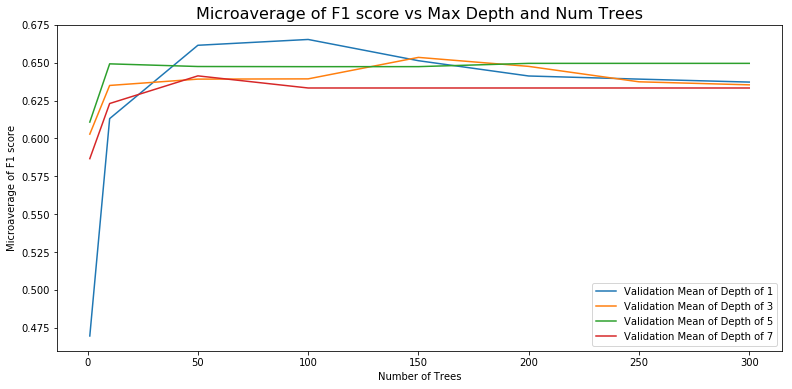

In [18]:
plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs Max Depth and Num Trees",
          fontsize=16)

plt.xlabel("Number of Trees")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()
# plt.xscale("log")
# ax.set_xlim(C[0], C[-1])

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)
X_axis_unique = np.unique(X_axis)

sample_score_mean = results['mean_test_score']

train_score_mean = results['mean_train_score']

plt.plot(X_axis_unique, sample_score_mean[0:8], label='Validation Mean of Depth of 1')
plt.plot(X_axis_unique, sample_score_mean[16:24], label='Validation Mean of Depth of 3')
plt.plot(X_axis_unique, sample_score_mean[32:40], label='Validation Mean of Depth of 5')
plt.plot(X_axis_unique, sample_score_mean[48:56], label='Validation Mean of Depth of 7')

plt.legend()

plt.grid(False)

# Evaluate on Validation set

In [20]:
df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)
print(train.shape)
print(val.shape)

(396, 44)
(100, 44)


In [24]:
train_X, train_y, pred_names = load_data.get_features_and_response(train)
val_X, val_y, pred_names = load_data.get_features_and_response(val)

In [25]:
gb_model = sklearn.ensemble.GradientBoostingClassifier(n_estimators=150, max_depth=1, random_state=229)
gb_model.fit(train_X, train_y)

estimates = gb_model.predict(val_X)

#### evaluate performance

Misclassified samples: 29
Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.73      0.73        26
           2       0.79      0.82      0.81        28
           3       0.67      0.72      0.69        25
           5       0.61      0.52      0.56        21

   micro avg       0.71      0.71      0.71       100
   macro avg       0.70      0.70      0.70       100
weighted avg       0.71      0.71      0.71       100



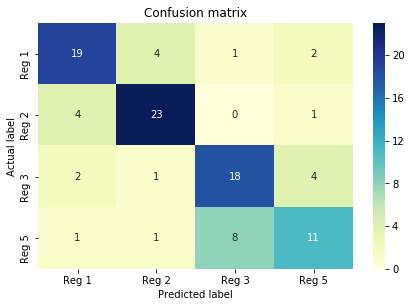

In [26]:
evaluate_performance(val_y, estimates)

# ------------------------------------------------------------------------------------------

# Now with adding the Extra Features

## Load Data

In [29]:
df, train, test = load_data.load_coral_data(complete=True, CV=True, convert_to_categorical=True)
print(train.shape)

(496, 44)


## Data Prep

In [30]:
train_X, train_y, pred_names = load_data.get_features_and_response(train, True)

In [31]:
print(train_X.shape)
pred_names

(496, 25)


Index(['Effluent', 'Sedimentation', 'New_Development', 'Habitat_Modification',
       'Invasive_Algae', 'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth', 'sqrt_power_x_compexity', 'log_power_over_depth',
       'complexity_over_depth', 'Irradiance_x_inv_algae', 'both_anomolies'],
      dtype='object')

# Try Cross Validation Code from Logistic

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, zero_one_loss
import time
num_trees = [1, 10, 50, 100, 150, 200, 250, 300]
depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
hyperparameters = dict(n_estimators=num_trees, max_depth=depth)

begin = time.time()
clf = GridSearchCV(sklearn.ensemble.GradientBoostingClassifier(random_state=229), 
                  hyperparameters, cv=5, verbose=1, iid=False,
                  scoring = make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                  return_train_score=True)
best_model = clf.fit(train_X, train_y)

print("That took {} seconds".format(time.time() - begin))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  3.8min finished


That took 229.45289492607117 seconds


In [33]:
# # Best Model is the model picked with the optimal C retrained on the
# # entire training data.

print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

Best n_estimators: 300
Best max_depth: 4


In [34]:
# from scikit-learn, "Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV" 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
results = clf.cv_results_

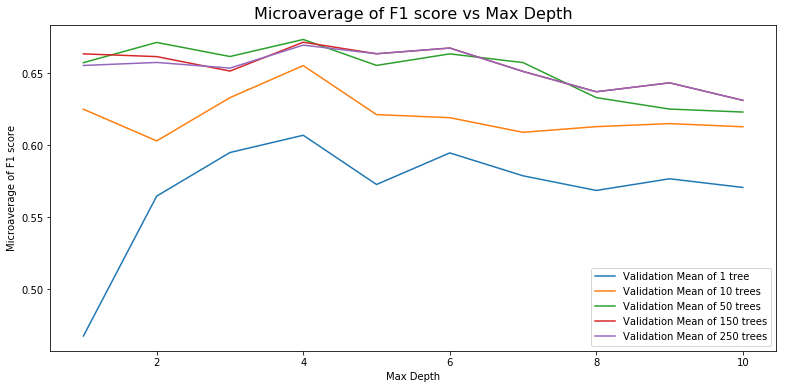

In [35]:
plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs Max Depth",
          fontsize=16)

plt.xlabel("Max Depth")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_depth'].data, dtype=float)
X_axis_unique = np.unique(X_axis)

sample_score_mean = results['mean_test_score']
# sample_score_std = results['std_test_score']

train_score_mean = results['mean_train_score']

plt.plot(X_axis_unique, sample_score_mean[range(0,80,8)], label='Validation Mean of 1 tree')
plt.plot(X_axis_unique, sample_score_mean[range(1,81,8)], label='Validation Mean of 10 trees')
plt.plot(X_axis_unique, sample_score_mean[range(2,82,8)], label='Validation Mean of 50 trees')
plt.plot(X_axis_unique, sample_score_mean[range(4,84,8)], label='Validation Mean of 150 trees')
plt.plot(X_axis_unique, sample_score_mean[range(6,86,8)], label='Validation Mean of 250 trees')

plt.legend()

plt.grid(False)

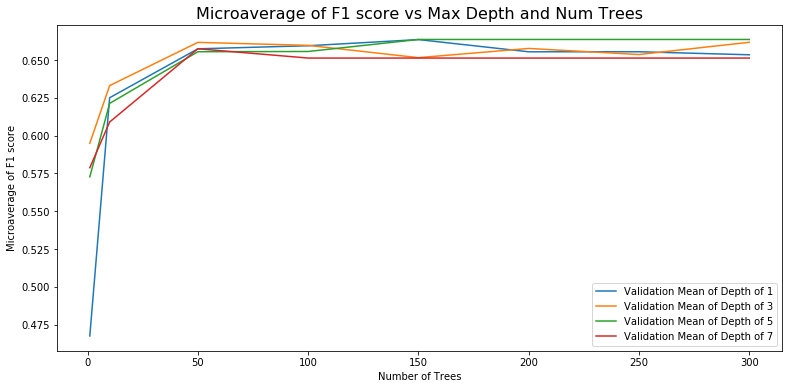

In [36]:
plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs Max Depth and Num Trees",
          fontsize=16)

plt.xlabel("Number of Trees")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()
# plt.xscale("log")
# ax.set_xlim(C[0], C[-1])

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)
X_axis_unique = np.unique(X_axis)

sample_score_mean = results['mean_test_score']

train_score_mean = results['mean_train_score']

plt.plot(X_axis_unique, sample_score_mean[0:8], label='Validation Mean of Depth of 1')
plt.plot(X_axis_unique, sample_score_mean[16:24], label='Validation Mean of Depth of 3')
plt.plot(X_axis_unique, sample_score_mean[32:40], label='Validation Mean of Depth of 5')
plt.plot(X_axis_unique, sample_score_mean[48:56], label='Validation Mean of Depth of 7')

plt.legend()

plt.grid(False)

# Evaluate on Validation set

In [38]:
df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)
print(train.shape)
print(val.shape)

(396, 44)
(100, 44)


In [39]:
train_X, train_y, pred_names = load_data.get_features_and_response(train, True)
val_X, val_y, pred_names = load_data.get_features_and_response(val, True)

In [40]:
gb_model = sklearn.ensemble.GradientBoostingClassifier(n_estimators=300, max_depth=4, random_state=229)
gb_model.fit(train_X, train_y)

estimates = gb_model.predict(val_X)

#### evaluate performance

Misclassified samples: 27
Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.81      0.78        26
           2       0.78      0.75      0.76        28
           3       0.66      0.76      0.70        25
           5       0.75      0.57      0.65        21

   micro avg       0.73      0.73      0.73       100
   macro avg       0.73      0.72      0.72       100
weighted avg       0.73      0.73      0.73       100



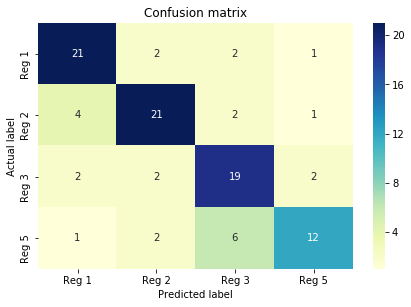

In [41]:
evaluate_performance(val_y, estimates)

# ------------------------------------------------------------------------------------------

# Error Analysis

In [ ]:
#What are the confidence scores for those predictions? 
# how do those confidence scores relate to the other predictions?

# are the predictors similar for those regimes? More similar than the others?

In [8]:
val_probs = gb_model.predict_proba(val_X)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [42]:
comb = pd.DataFrame({"val_y":val_y, "val_est":val_estimates})
misclass_idxs = np.where(val_y != val_estimates)
print(len(misclass_idxs[0]))

18


In [40]:
comb.loc[misclass_idxs]

,val_y,val_est
5,3,5
19,3,5
23,3,1
30,3,5
36,5,3
37,3,5
46,3,5
51,2,3
53,2,5
56,5,2


In [28]:
def to_0_3(array):
    array = array.copy()
    array[array==1] = 0
    array[array==2] = 1
    array[array==3] = 2
    array[array==5] = 3
    return array
    
def back_to_1_5(array):
    array = array.copy()
    array[array==3] = 5
    array[array==2] = 3
    array[array==1] = 2
    array[array==0] = 1
    return array

In [48]:
predicted_class_probs = val_probs[range(100),to_0_3(val_estimates)]
misclasses = predicted_class_probs[np.where(val_y != val_estimates)]
misclasses

array([0.99991639, 0.62002004, 0.76083493, 0.98640123, 0.99786503,
       0.71640264, 0.99399373, 0.99966789, 0.95693121, 0.99935088,
       0.99695948, 0.53198882, 0.89982328, 0.95610743, 0.99981668,
       0.94082312, 0.55474928, 0.98910805])

In [47]:
fives_threes = [0,1,3,4,5,6,10,13,16,17]
misclasses[fives_threes]

array([0.99991639, 0.62002004, 0.98640123, 0.99786503, 0.71640264,
       0.99399373, 0.99695948, 0.95610743, 0.55474928, 0.98910805])

Text(0.5, 1.0, "Probability of Misclasses of 3's as 5's")

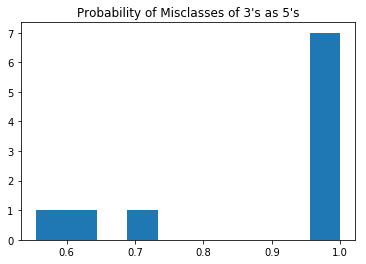

In [53]:
plt.hist(misclasses[fives_threes])
plt.title("Probability of Misclasses of 3's as 5's")

It's pretty confident when it's misclassifying between 3's and 5's

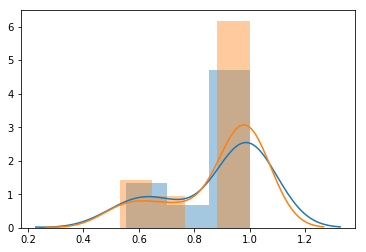

In [57]:
sns.distplot(misclasses[fives_threes], norm_hist=True)
sns.distplot(misclasses, norm_hist=True)

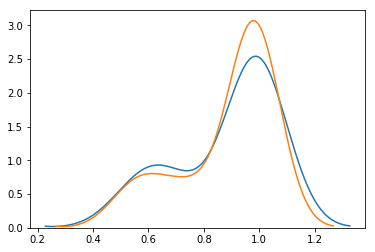

In [65]:
sns.distplot(misclasses[fives_threes], hist=False)
sns.distplot(misclasses, hist=False)